In [1]:
from source import Dataset
from source import tools
import awkward as ak
import glob
import time

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import optimizers
from keras import layers

import os
import tempfile

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import sklearn
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

2023-12-05 18:34:13.168378: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-05 18:34:13.352751: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-12-05 18:34:13.352788: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-12-05 18:34:14.812219: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-

In [2]:
#selecting features 
branches_to_train = [
"cscRechitClusterX",
"cscRechitClusterY",
"cscRechitClusterZ",
"cscRechitClusterTimeWeighted",
"cscRechitClusterTimeSpreadWeightedAll",
"cscRechitClusternXY",
"cscRechitClusternZ",
"cscRechitClusterXSpread",
"cscRechitClusterYSpread",
"cscRechitClusterZSpread",
"cscRechitClusterXYSpread",
"cscRechitClusterRSpread",
"cscRechitClusterEtaPhiSpread",
"cscRechitClusterEtaSpread",
"cscRechitClusterPhiSpread",
"cscRechitClusterDeltaRSpread",
"cscRechitClusterMajorAxis",
"cscRechitClusterMinorAxis",
"cscRechitClusterSkewX",
"cscRechitClusterSkewY",
"cscRechitClusterSkewZ",
"cscRechitClusterKurtX",
"cscRechitClusterKurtY",
"cscRechitClusterKurtZ",
"cscRechitClusterSize",
]

#padded_branches_to_train = []
#for col in branches_to_train:           
#    #creates padded column for each jet of each "Jets/Jets." key
#    for icol in range(10):
#        new_col_name = col+"_"+str(icol)
#        padded_branches_to_train.append(new_col_name)

#branches_to_train = [
#    "cscRechitClusterSize",
#]

print(branches_to_train)
truth_value = "cscRechitCluster_match_gLLP_e"


['cscRechitClusterX', 'cscRechitClusterY', 'cscRechitClusterZ', 'cscRechitClusterTimeWeighted', 'cscRechitClusterTimeSpreadWeightedAll', 'cscRechitClusternXY', 'cscRechitClusternZ', 'cscRechitClusterXSpread', 'cscRechitClusterYSpread', 'cscRechitClusterZSpread', 'cscRechitClusterXYSpread', 'cscRechitClusterRSpread', 'cscRechitClusterEtaPhiSpread', 'cscRechitClusterEtaSpread', 'cscRechitClusterPhiSpread', 'cscRechitClusterDeltaRSpread', 'cscRechitClusterMajorAxis', 'cscRechitClusterMinorAxis', 'cscRechitClusterSkewX', 'cscRechitClusterSkewY', 'cscRechitClusterSkewZ', 'cscRechitClusterKurtX', 'cscRechitClusterKurtY', 'cscRechitClusterKurtZ', 'cscRechitClusterSize']


In [3]:
#dataset_signal = Dataset.Dataset("signal")
#loaded_array_signal = dataset_signal.load("/nfs/dust/cms/user/lbenato/ML_LLP/MDS_regression/datasets/test_v6.h5")

In [4]:
dataset_signal = Dataset.Dataset("signal")
df_signal = dataset_signal.load_df("/nfs/dust/cms/user/loewetob/ML_LLP/MDS_regression/datasets/test_df_v6.h5")

Opening file  /nfs/dust/cms/user/loewetob/ML_LLP/MDS_regression/datasets/test_df_v6.h5


In [5]:
df_signal.shape

(90016, 79)

In [6]:
#Consider only data with proper gen matching
df_signal = df_signal[ df_signal["cscRechitCluster_match_gLLP"]>=1 ]

In [7]:
df_signal.shape

(79780, 79)

In [8]:
print(df_signal)

          weight  evtNum  cscRechitCluster_match_gLLP  \
entry                                                   
0      23.164499  502880                         True   
1      23.164499  502904                         True   
2      23.164499  502907                         True   
3      23.164499  502907                         True   
4      23.164499  502929                         True   
...          ...     ...                          ...   
90008  23.164499  552795                         True   
90009  23.164499  552829                         True   
90011  23.164499  552858                         True   
90012  23.164499  552905                         True   
90014  23.164499  552967                         True   

       cscRechitCluster_match_gLLP_minDeltaR  \
entry                                          
0                                   0.021920   
1                                   0.019714   
2                                   0.076979   
3                 

In [9]:
#splitting the data into train, test and validation
#from sklearn.model_selection import train_test_split
#
#loaded_array_signal_64 = dataset_signal.get_unstructured_numpy(loaded_array_signal)
#print(loaded_array_signal.dtype)
#print(loaded_array_signal_64.dtype)
#    
#loaded_array_signal_df = loaded_array_signal_64
#
#print(loaded_array_signal_64)

In [10]:
# Splitting the loaded_array_signal data
#train_data, testval_data = train_test_split(loaded_array_signal_df, train_size=0.6)
train_data, testval_data = train_test_split(df_signal, train_size=0.6)
test_data, val_data = train_test_split(testval_data, test_size=0.5)

# assigning labels
train_labels = np.array(train_data[truth_value])#([1.]*len(train_data))
test_labels = np.array(test_data[truth_value])#([1.]*len(test_data))
val_labels = np.array(val_data[truth_value])#([1.]*len(val_data))

train_data = train_data[branches_to_train]
test_data = test_data[branches_to_train]
val_data = val_data[branches_to_train]

# check the shape
print("First example:")
print("signal training features", train_data.shape)
print("signal training labels", train_labels.shape)
print("signal test features", test_data.shape)
print("signal test labels", test_labels.shape)
print("signal val features", val_data.shape)
print("signal val labels", val_labels.shape)

print(train_labels)
print(train_data[branches_to_train])

#print(type(train_data), type(train_labels))
n_features = train_data.shape[1]

First example:
signal training features (47868, 25)
signal training labels (47868,)
signal test features (15956, 25)
signal test labels (15956,)
signal val features (15956, 25)
signal val labels (15956,)
[199.01322937 182.73242188 113.65991974 ... 279.75112915 227.94953918
  96.92224884]
       cscRechitClusterX  cscRechitClusterY  cscRechitClusterZ  \
entry                                                            
84388        -420.029541         -72.700020       -1037.113525   
72213         374.567383         -37.660690        -986.000305   
25374        -242.311111        -568.895264        1023.641174   
65043         -91.565620         488.775360        -700.443542   
32023          24.781168        -511.388153        1037.254395   
...                  ...                ...                ...   
86173         198.232788        -409.914398        -900.760071   
58673         351.279755        -278.464539         709.650574   
21699        -149.724426        -163.714813       -

In [11]:
n_features

25

In [12]:
# concatenate data
#train_data = np.concatenate([bkg_train_data,sig_train_data], axis=0)
#test_data = np.concatenate([bkg_test_data, sig_test_data], axis=0)
#val_data = np.concatenate([bkg_val_data, sig_val_data], axis=0)

#train_labels = np.concatenate([bkg_train_labels, sig_train_labels], axis=0)
#test_labels = np.concatenate([bkg_test_labels, sig_test_labels], axis=0)
#val_labels = np.concatenate([bkg_val_labels, sig_val_labels], axis=0)

print("training features", train_data.shape)
print("training labels", train_labels.shape)
print("test features", test_data.shape)
print("test labels", test_labels.shape)
print("val features", val_data.shape)
print("val labels", val_labels.shape)
print(val_labels)

training features (47868, 25)
training labels (47868,)
test features (15956, 25)
test labels (15956,)
val features (15956, 25)
val labels (15956,)
[110.79071045  94.03301239 324.23059082 ...  78.27667236 161.04466248
  50.52373505]


In [13]:
 # shuffle

X_train, Y_train = sklearn.utils.shuffle(train_data, train_labels, random_state=0) # change to random_state=None for full randomness
X_test, Y_test = sklearn.utils.shuffle(test_data, test_labels, random_state=0) # change to random_state=None for full randomness
X_val, Y_val = sklearn.utils.shuffle(val_data, val_labels, random_state=0) # change to random_state=None for full randomness

print("shuffled training features", X_train)
print("shuffled training features", X_train.shape)
print("shuffled training labels", Y_train)
print("shuffled training labels", Y_train.shape)
print(train_data.shape)

shuffled training features        cscRechitClusterX  cscRechitClusterY  cscRechitClusterZ  \
entry                                                            
30667          57.752052        -187.762177        -600.031799   
63877        -450.587189         -68.538643        -819.226074   
19810        -178.435547         501.905304         697.198059   
73243         203.608841         -39.287140         990.071045   
49746         -96.158745        -222.519318         942.624268   
...                  ...                ...                ...   
30312         179.876923        -154.623260       -1018.670471   
35602         117.167793         -22.714344        -610.494141   
38016         185.505386        -387.788452        -697.474121   
5043         -269.453278          55.211357        -682.170776   
67546        -217.071823        -521.970947         693.657898   

       cscRechitClusterTimeWeighted  cscRechitClusterTimeSpreadWeightedAll  \
entry                               

In [14]:
#defining the model and metrics
METRICS = [
      keras.metrics.BinaryCrossentropy(name='cross entropy'),  # same as model's loss
      keras.metrics.MeanSquaredError(name='Brier score'),
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]


def make_model(metrics=METRICS, output_bias=None):
    if output_bias is not None:
        output_bias = tf.keras.initializers.Constant(output_bias)
    #initializer = tf.keras.initializers.RandomNormal(mean=0., stddev=1.)
    #initializer = tf.keras.initializers.RandomUniform(minval=0., maxval=200, seed=None)
    initializer = tf.keras.initializers.Constant(value=100)

    
    model = keras.Sequential([
        #keras.layers.Dense(5, activation='relu', input_shape=(n_features,), kernel_initializer=initializer, bias_initializer=None),
        #keras.layers.Dropout(0.5),
        #keras.layers.Dense(1, activation='relu', bias_initializer=output_bias, kernel_initializer=initializer)
        #Attempt:
        keras.layers.Dense(50, activation='relu', input_shape=(n_features,), kernel_initializer=initializer, bias_initializer=None),
        keras.layers.Dense(30, activation='relu'),
        keras.layers.Dense(20, activation='relu'),
        keras.layers.Dense(5, activation='relu'),
        #keras.layers.Dense(1, activation='relu', input_shape=(n_features,), kernel_initializer=initializer, bias_initializer=None),
        keras.layers.Dense(1)

    ])
    
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=1e-3),
        #optimizer=keras.optimizers.SGD(learning_rate=0.01),
        #loss=keras.losses.BinaryCrossentropy(),
        loss=keras.losses.MeanSquaredError(name='MSE'),
        metrics=metrics
    )
    
    return model

# TODO: Find best way to init weights

In [15]:
EPOCHS = 100
BATCH_SIZE = 1024

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', #val_prec
    verbose=1,
    patience=10,
    mode='min',#max
    restore_best_weights=True)

In [16]:
model = make_model()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 50)                1300      
                                                                 
 dense_1 (Dense)             (None, 30)                1530      
                                                                 
 dense_2 (Dense)             (None, 20)                620       
                                                                 
 dense_3 (Dense)             (None, 5)                 105       
                                                                 
 dense_4 (Dense)             (None, 1)                 6         
                                                                 
Total params: 3,561
Trainable params: 3,561
Non-trainable params: 0
_________________________________________________________________


In [17]:
output = model.predict(X_train)
print(output)
print(Y_train)

1496/1496 [==============================] - 1s 484us/step
[[ -10825.446]
 [      0.   ]
 [-127778.52 ]
 ...
 [      0.   ]
 [ -23836.03 ]
 [ -75046.19 ]]
[260.51358032 181.16201782  89.73949432 ...  54.7366333   71.17505646
  94.03398132]


In [18]:
results = model.evaluate(X_train, Y_train, batch_size=BATCH_SIZE, verbose=0)
print("Loss: {:0.4f}".format(results[0]))

Loss: 20175882240.0000


In [19]:
model = make_model()
history = model.fit(
    X_train,
    Y_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS, #EPOCHS
    callbacks=[early_stopping],
    validation_data=(X_val, Y_val))

Epoch 1/100
479/479 [==============================] - 2s 3ms/step - loss: 60656096.0000 - cross entropy: 459.1183 - Brier score: 10118257664.0000 - tp: 34979.0000 - fp: 0.0000e+00 - tn: 0.0000e+00 - fn: 60757.0000 - accuracy: 0.0000e+00 - precision: 1.0000 - recall: 0.3654 - auc: 0.0000e+00 - prc: 1.0000 - val_loss: 17067.8203 - val_cross entropy: -1875.1830 - val_Brier score: 17067.8203 - val_tp: 12792.0000 - val_fp: 0.0000e+00 - val_tn: 0.0000e+00 - val_fn: 3164.0000 - val_accuracy: 0.0000e+00 - val_precision: 1.0000 - val_recall: 0.8017 - val_auc: 0.0000e+00 - val_prc: 1.0000
Epoch 2/100
479/479 [==============================] - 1s 2ms/step - loss: 16466.0703 - cross entropy: -2147.5044 - Brier score: 16466.0703 - tp: 44106.0000 - fp: 0.0000e+00 - tn: 0.0000e+00 - fn: 3762.0000 - accuracy: 0.0000e+00 - precision: 1.0000 - recall: 0.9214 - auc: 0.0000e+00 - prc: 1.0000 - val_loss: 14806.6328 - val_cross entropy: -2362.2891 - val_Brier score: 14806.6328 - val_tp: 15956.0000 - val_fp

479/479 [==============================] - 1s 2ms/step - loss: 11010.2236 - cross entropy: -2356.2603 - Brier score: 11010.2236 - tp: 47597.0000 - fp: 0.0000e+00 - tn: 0.0000e+00 - fn: 271.0000 - accuracy: 0.0000e+00 - precision: 1.0000 - recall: 0.9943 - auc: 0.0000e+00 - prc: 1.0000 - val_loss: 10279.6904 - val_cross entropy: -2362.2891 - val_Brier score: 10279.6904 - val_tp: 15956.0000 - val_fp: 0.0000e+00 - val_tn: 0.0000e+00 - val_fn: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_precision: 1.0000 - val_recall: 1.0000 - val_auc: 0.0000e+00 - val_prc: 1.0000
Epoch 16/100
479/479 [==============================] - 1s 2ms/step - loss: 15110.3291 - cross entropy: -2191.1973 - Brier score: 15110.3291 - tp: 46001.0000 - fp: 0.0000e+00 - tn: 0.0000e+00 - fn: 1867.0000 - accuracy: 0.0000e+00 - precision: 1.0000 - recall: 0.9610 - auc: 0.0000e+00 - prc: 1.0000 - val_loss: 77492.1719 - val_cross entropy: 754.5632 - val_Brier score: 77492.1719 - val_tp: 5843.0000 - val_fp: 0.0000e+00 - val_tn:

In [20]:
pred_output = model.predict(X_train[:10])
print(pred_output)
print(Y_train[:10])

results = model.evaluate(X_train, Y_train, batch_size=BATCH_SIZE, verbose=0)
print("Loss on training: {:0.4f}".format(results[0]))

results_val = model.evaluate(X_val, Y_val, batch_size=BATCH_SIZE, verbose=0)
print("Loss on validation: {:0.4f}".format(results_val[0]))

1/1 [==============================] - 0s 77ms/step
[[ 47.132034]
 [147.55548 ]
 [ 95.17598 ]
 [200.82442 ]
 [ 83.79317 ]
 [126.51582 ]
 [ 74.27754 ]
 [ 54.160355]
 [147.55548 ]
 [102.904495]]
[260.51358032 181.16201782  89.73949432 286.19677734 118.98925781
 201.83940125  80.07064819  77.0490036  231.94145203 103.61458588]
Loss on training: 8835.0967
Loss on validation: 8702.8711


In [21]:
# Plots of loss vs epoch 
# Plot of ROC

train_predictions = model.predict(train_data, batch_size=BATCH_SIZE)
test_predictions = model.predict(test_data, batch_size=BATCH_SIZE)
print(len(test_data),len(test_predictions))

16/16 [==============================] - 0s 1ms/step
15956 15956


In [22]:
print(history.history['loss'])
print(history.history['val_loss'])
print(history.history.keys())

[60656096.0, 16466.0703125, 17650.4765625, 50370.625, 1541952.625, 18736.92578125, 133165.921875, 1464034.5, 23074.76171875, 1419841.625, 173218.15625, 607435.875, 2825410.25, 22409.845703125, 11010.2236328125, 15110.3291015625, 197955.515625, 36587.25390625, 186821.96875, 609288.875, 309113.75, 17169.205078125, 32583.232421875, 199024.71875]
[17067.8203125, 14806.6328125, 20946.638671875, 14090.0400390625, 48579.796875, 11632.740234375, 9433.728515625, 98682.2109375, 9692.6279296875, 17283.658203125, 306013.625, 213641.703125, 403439.5, 8702.87109375, 10279.6904296875, 77492.171875, 11092.921875, 1027500.0, 11737.5263671875, 121264.8125, 10619.267578125, 11931.51953125, 138066.3125, 15392.7041015625]
dict_keys(['loss', 'cross entropy', 'Brier score', 'tp', 'fp', 'tn', 'fn', 'accuracy', 'precision', 'recall', 'auc', 'prc', 'val_loss', 'val_cross entropy', 'val_Brier score', 'val_tp', 'val_fp', 'val_tn', 'val_fn', 'val_accuracy', 'val_precision', 'val_recall', 'val_auc', 'val_prc'])


In [23]:
#AUC
#sklearn.metrics.roc_auc_score(test_labels, test_predictions_baseline)

In [24]:
#sklearn.metrics.roc_auc_score(train_labels, train_predictions_baseline)

In [25]:
from source.tools import tools
obj = tools()
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

def plot_metrics(history):
    metrics = ['loss', 'prc', 'precision', 'recall']
    metrics = ['loss', 'Brier score', 'precision', 'recall']
    fig, axs = plt.subplots(2, 2, figsize=(10, 8))
    fig.subplots_adjust(hspace=0.3)  # Adjust the vertical spacing between subplots

    for n, metric in enumerate(metrics):
        name = metric.replace("_"," ").capitalize()
        plt.subplot(2,2,n+1)
        plt.plot(history.epoch, history.history[metric], color=colors[0], label='Train')
        plt.plot(history.epoch, history.history['val_'+metric],
                 color=colors[0], linestyle="--", label='Val')
        plt.xlabel('Epoch')
        plt.ylabel(name)
        if metric == 'loss':
            plt.ylim([1, plt.ylim()[1]])
            plt.yscale("log")
        elif metric == 'auc':
            plt.ylim([0.8,1])
        elif metric == 'Brier score':
            plt.ylim([0.1,12527118336])
            plt.yscale("log")
        else:
            plt.ylim([0,1.1])

        plt.legend()

[10118257664.0, 16466.0703125, 17650.4765625, 50370.6328125, 1541952.625, 18736.92578125, 133165.921875, 1464034.5, 23074.76171875, 1419841.625, 173218.15625, 607435.875, 2825410.25, 22409.845703125, 11010.2236328125, 15110.3291015625, 197955.515625, 36587.25390625, 186821.96875, 609288.875, 309113.75, 17169.205078125, 32583.232421875, 199024.71875]


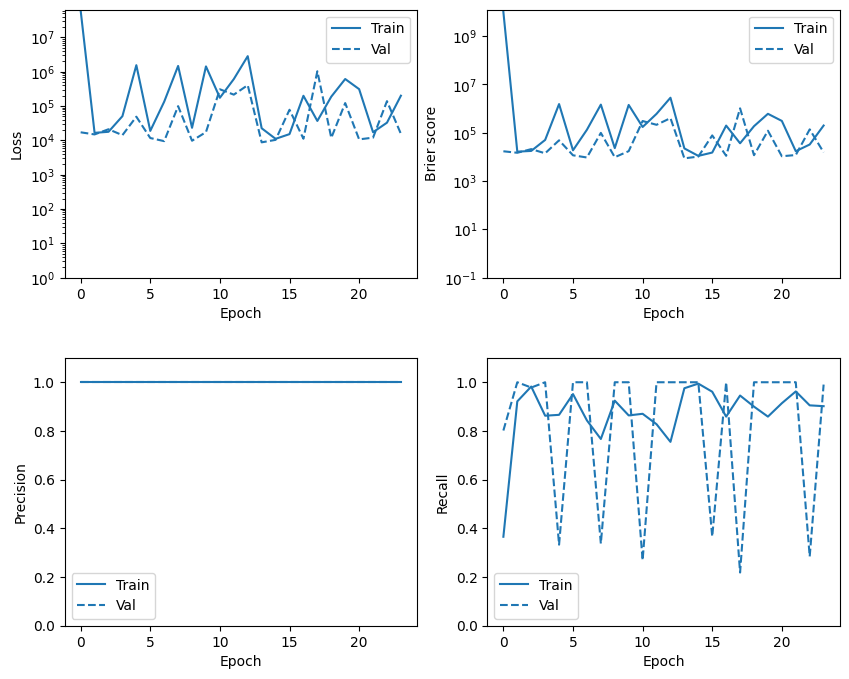

In [26]:
plot_metrics(history)
print(history.history['Brier score'])

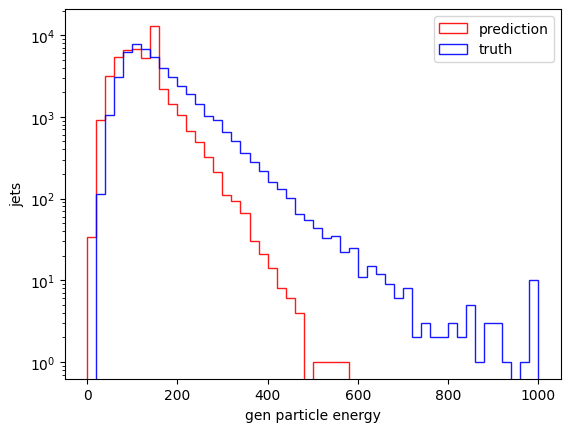

[[147.55548]
 [ 97.29317]
 [ 90.87129]
 ...
 [166.64473]
 [128.28535]
 [ 74.57442]]


In [27]:
obj = tools()
obj.plotHist(train_predictions,train_labels, bins = 50, interval=[0,1000] ,logy=True, logx=False, labels=["prediction","truth"],
             xlabel= 'gen particle energy', density=False, ax=None, moveOverUnderFlow=True, verbosity = 0)

#obj.plotHist(test_predictions_signal, test_predictions_background, bins = 50, interval=[0,1], logy=True, logx=False, labels=["signal test", "background test"],
#             xlabel= 'DNN output', density=False, ax=None, moveOverUnderFlow=True, verbosity = 0)

print(train_predictions)

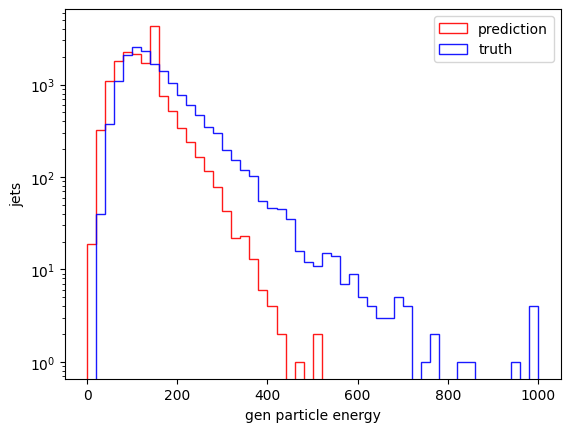

In [28]:
obj = tools()
obj.plotHist(test_predictions,test_labels, bins = 50, interval=[0,1000] ,logy=True, logx=False, labels=["prediction","truth"],
             xlabel= 'gen particle energy', density=False, ax=None, moveOverUnderFlow=True, verbosity = 0)